**This code computes the decomposed solution using Benders Decomposition of the stochastic market clearing example**

- The original reference of this problem is:
https://drive.google.com/file/d/1hIH1pYXcNPlTpUnFUAnY_y4jHcrIzwWv/view

--> Before runing this code, we need to install Julia and its package JuMP. For solving the linear system, we need to download and install CPLEX 

AUTHOR: Jose Matias <assumpcj@mcmaster.ca>
DATE: November 2023

In [1]:
using JuMP, CPLEX, Printf, Plots

# Simplified Energy Market

<div>
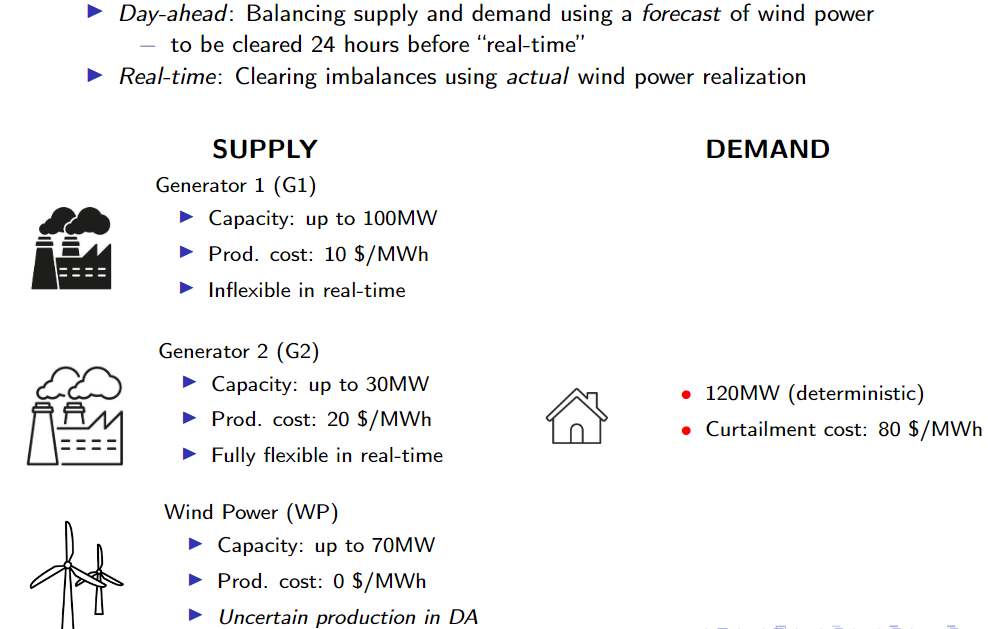
</div>

## Declaring system parameters

In [2]:
# costs
cS1 = [10,20] # stage 1 costs
cS2 = [20,80] # stage 2 costs

# uncertain WP production DA (equiprobable scenarios)
pi_w = [0.25,0.25,0.25,0.25]

# uncertain production DA
phi = [30,60,70,10];

# Original Optimization problem

$\min_{\mathcal{P}} \quad [10 p^{G1,DA}  + 20 p^{G2,DA}] + \sum_{s = 1}^4 \pi_s \ [20 p^{G2,RT}_{s} + 80 p^{shed}_{s}]$

$\textrm{s.t.} $<br>
$0 \leq p^{G1,DA} \leq 120 $<br>
$0 \leq p^{G2,DA} \leq 30 $<br>
$0 \leq p^{WP,DA} \leq 70 $ <br>
$p^{G1,DA} + p^{G2,DA} + p^{WP,DA} = 120 $<br>

>    $ s = 1,2,3,4$<br>
>    $0 \leq p^{spill}_s \leq \phi_s$ <br>
>    $0 \leq p^{shed}_s \leq 120$<br>
>    $-30 \leq p^{G2,RT}_s \leq 30$<br>
>    $0 \leq \big(p^{G2,DA} + p^{G2,RT}_s\big)\leq 30 $<br>
>    $p^{G2,RT}_s + \big(\phi_s - p^{WP,DA} - p^{spill}_s\big) + p^{shed}_s = 0 $


where, <br>
$p^{G1,DA}$: Generator 1 day ahead dispatch  <br>
$p^{G2,DA}$: Generator 2 day ahead dispatch  <br>
$p^{WP,DA}$: Wind power capacity <br>

$s$: scenario index $\{1,2,3,4\}$ <br>

$\phi_s$: Wind power forecast $[30,60,70,10]$ <br>
$p^{spill}_s$: Wind power spillage <br>
$p^{shed}_s$: Load shedding<br>
$p^{G2,RT}_s$: Generator 2 real-time flexibility

# Benders Decomposition

<div>
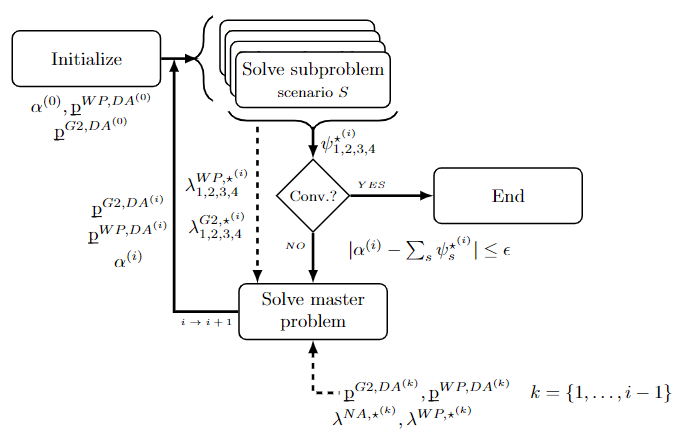
</div>

## Modeling master problem

In [3]:
# bound
alpha_down = -6000;

# calling optimizer
master = Model(CPLEX.Optimizer)
set_silent(master)

# problem variables
@variable(master, 0 ≤ p_da_g1 ≤ 100, start = 90)
@variable(master, 0 ≤ p_da_g2 ≤ 30, start = 30)
@variable(master, 0 ≤ p_da_w ≤ 70, start = 0)
@variable(master, α ≥ alpha_down)

# problem constraints @ iteration 1
@constraint(master, p_da_g1 + p_da_g2 + p_da_w == 120)

# objective function
@objective(master, Min, cS1[1]*p_da_g1 + cS1[2]*p_da_g2 + α);

## Modeling subproblem

Solved for each scenario

In [4]:
function subp(p_cv_fixed,phi_unc_s,prob_s)
    # inputs:
    # - p_nc_fixed = complicating variable value 
    # - phi_unc_s = value of the uncertain WP forecast (scenario s)
    # - prob_s = probability of uncertain WP realization
    
    # building subproblem model
    sub = Model(CPLEX.Optimizer)
    set_silent(sub)
    
    # "copied" variables as master problem 
    @variable(sub,p_da_g2)
    @variable(sub,p_da_w)
    
    # subproblem (exclusive) variables
    @variable(sub, -30 ≤ p_rt_g2 ≤ 30)
    @variable(sub, 0 ≤ p_w_spill ≤ phi_unc_s)
    @variable(sub, 0 ≤ p_shed ≤ 120)
    
    @constraint(sub, 0 ≤ p_da_g2 + p_rt_g2 ≤ 30)
    @constraint(sub, p_rt_g2 + (phi_unc_s -  p_da_w - p_w_spill) + p_shed == 0) #Aff = 0: 1
    
    @constraint(sub, p_da_g2 - p_cv_fixed[1] == 0) #Aff = 0: 2
    @constraint(sub, p_da_w - p_cv_fixed[2] == 0) #Aff = 0: 3
    
    @objective(sub, Min, prob_s*(cS2[1]*p_rt_g2 + cS2[2]*p_shed))
    #print(sub)
    #@show sub
    
    optimize!(sub)
    #a = termination_status(sub)
    
    #calling values of the solved subproblem
    o = objective_value(sub)
    r = value(p_rt_g2)
    s = value(p_w_spill)
    c = value(p_shed)
    
    # bundle of constraints of a given type
    all_con = all_constraints(sub, AffExpr, MOI.EqualTo{Float64})
    #print(all_con)
    
    # extracting the dual variables associated with these constraints
    λ = dual.(all_con)
    
    return Dict('o' => o, 'λ' => λ, 'r' => r, 's' => s, 'c' => c)
end;

## Auxiliary function for printing iteration information

In [5]:
function print_iteration(k, args...)
    f(x) = Printf.@sprintf("%12.4e",x)
    println(lpad(k,9), " ",join(f.(args), " "))
    return
end;

## Implementing BD

In [6]:
# preparing plot of the objective value evoluation
p = plot(xlabel="iteration", ylabel="OF value");

In [7]:
# preparing header for showing information on screen
println("        i  p_da_g1       p_da_g2       p_da_w      lowerbound   upperbound   gap")

for ii in 1:100

    ####################
    # STEP 1 & STEP 3b #
    ###################
    # Step 1: instead of guessing the initial values, I solve a master problem to obtain p_da_g2⁰, p_da_wp⁰, and α⁰
    # Step 3b: Solve master problem to obtain p_da_g2ⁱ, p_da_wpⁱ and αⁱ
    
    # solve master problem
    optimize!(master)
    
    # solution of the master problem is a lower bound of the original problem
    lb = objective_value(master)
    
    # extracting variables of the master problem solution
    p_da_g1ⁱ = value(p_da_g1) #not a complicating variable
    p_da_g2ⁱ = value(p_da_g2)
    p_da_wⁱ = value(p_da_w)
    
    ##########
    # STEP 2 #
    ##########
    # Step 2: Solve subproblems to obtain the sensitivities λ
    
    # sensitivity (num scenario, num var)
    lambda_M = [subp([p_da_g2ⁱ,p_da_wⁱ],phi[ss],pi_w[ss])['λ'] for ss in 1:4]
    
    # objective function
    sum_psi = sum(subp([p_da_g2ⁱ,p_da_wⁱ],phi[ss],pi_w[ss])['o'] for ss in 1:4)
    
    # solution of the subproblems is an upper bound of the original problem cost
    ub = cS1[1]*p_da_g1ⁱ + cS1[2]*p_da_g2ⁱ + sum_psi
    
    # compute optimality gap
    gap = abs(ub - lb)/abs(ub)
    
    # print iteration information
    print_iteration(ii,p_da_g1ⁱ,p_da_g2ⁱ,p_da_wⁱ,lb,ub,gap)

    if ii == 1
        plot!([ii],[lb], marker=:circle,  markercolor = :green, label = "subproblem")
        plot!([ii],[ub], marker=:square, markercolor = :red, label = "master")
    else
        plot!([ii],[lb], marker=:circle,  markercolor = :green, label = "")
        plot!([ii],[ub], marker=:square, markercolor = :red, label = "")
    end
    
    ##########
    # STEP 3 #
    ##########
    # Step 3a: Convergence check --> check if optimality gap is small enough
    if gap < 1e-5
        println(" **** solution found ********")
        println("        s  p_rt_g2       p_spill      p_shed")
        for ss in 1:4
            rt = subp([p_da_g2ⁱ,p_da_wⁱ],phi[ss],pi_w[ss])['r']
            spill = subp([p_da_g2ⁱ,p_da_wⁱ],phi[ss],pi_w[ss])['s']
            shed = subp([p_da_g2ⁱ,p_da_wⁱ],phi[ss],pi_w[ss])['c']
            print_iteration(ss,rt,spill,shed)
        end
        
        break
    end
    
    # Step 3b: Adding optimiality cut
    benderscut = @constraint(master, α ≥ sum_psi + sum(lambda_M[ss][2] for ss in 1:4)*(p_da_g2 - p_da_g2ⁱ) + sum(lambda_M[ss][3] for ss in 1:4)*(p_da_w - p_da_wⁱ))
    
#     if ii == 1
#         @info "Adding this bender cut $(benderscut)"
#     end
end

        i  p_da_g1       p_da_g2       p_da_w      lowerbound   upperbound   gap
        1   5.0000e+01   0.0000e+00   7.0000e+01  -5.5000e+03   1.6500e+03   4.3333e+00
        2   1.0000e+02   2.0000e+01   0.0000e+00  -1.0000e+02   1.0500e+03   1.0952e+00
        3   7.1250e+01   3.0000e+01   1.8750e+01   9.0625e+02   1.1312e+03   1.9890e-01
        4   7.1250e+01   7.5000e+00   4.1250e+01   9.0625e+02   1.1312e+03   1.9890e-01
        5   8.2500e+01   3.0000e+01   7.5000e+00   9.6250e+02   1.0000e+03   3.7500e-02
        6   8.2500e+01   2.6250e+01   1.1250e+01   9.6250e+02   1.0000e+03   3.7500e-02
        7   8.0000e+01   3.0000e+01   1.0000e+01   1.0000e+03   1.0000e+03   0.0000e+00
 **** solution found ********
        s  p_rt_g2       p_spill      p_shed
        1  -2.0000e+01   0.0000e+00   0.0000e+00
        2  -3.0000e+01   2.0000e+01   0.0000e+00
        3  -3.0000e+01   3.0000e+01   0.0000e+00
        4   0.0000e+00   0.0000e+00   0.0000e+00


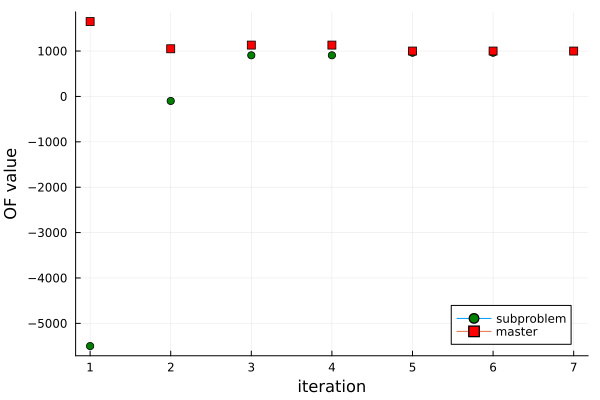

In [8]:
display(p)